# Purpose

This notebook contains random tidbits of code that may be useful for the project.


In [1]:
# What this does is it prints out the GPIO pins that are currently in use, and whether they're input, output, etc.

# # GPIO Purposes
# GPIO.setmode(GPIO.BCM)
# GPIO_ids = {
#     GPIO.IN: "IN",
#     GPIO.OUT: "OUT",
#     GPIO.SPI: "SPI",
#     GPIO.I2C: "I2C",
#     GPIO.HARD_PWM: "HARD_PWM",
#     GPIO.SERIAL: "SERIAL",
#     GPIO.UNKNOWN: "UNKNOWN"
# }
# 
# # Print out the active channels
# for pin in range(40):
#     function = GPIO.gpio_function(pin)
#     purpose = GPIO_ids.get(function, "UNKNOWN")
#     print(f"GPIO {pin} is {purpose}")
#     
# # GPIO.cleanup()


In [2]:
# duty_cycle_l, duty_cycle_r = controller.drive(0.5, 0, robot.wl, robot.wr)
# print(f"{duty_cycle_l}, {duty_cycle_r}")


# Some code that helps you to see if encoder calculations / odometry is working
import RPi.GPIO as GPIO
import gpiozero
import time
import numpy as np
from matplotlib import pyplot as plt
GPIO.cleanup()

GPIO.setmode(GPIO.BCM)

ML_ENC_A = 15 # yellow encoder c 23
ML_ENC_B = 14 # white encoder c 24

MR_ENC_A = 24 # yellow encoder c
MR_ENC_B = 23 # white encoder c
MAX_ENC_STEPS = 3600

# Motor Pins
ML_IN1 = 17 # IN1 10
ML_IN2 = 27 # IN2 22
ML_ENA = 11 # brown 9

MR_IN3 = 22 # IN3
MR_IN4 = 10 # IN4
MR_ENB = 9

# Physical dimensions
WHEEL_RADIUS = 0.056 # meters
WHEEL_SEP = 0.222 # meters

class DiffDriveRobot:
    def __init__(
            self, 
            dt=0.1, 
            wheel_radius=WHEEL_RADIUS, 
            wheel_sep=WHEEL_SEP,
            max_enc_steps=MAX_ENC_STEPS,
            ml_pwm=ML_ENA,
            mr_pwm=MR_ENB,
            ml_in1=ML_IN1,
            ml_in2=ML_IN2,
            mr_in3=MR_IN3,
            mr_in4=MR_IN4,
            ml_encA=ML_ENC_A,
            ml_encB=ML_ENC_B,
            mr_encA=MR_ENC_A,
            mr_encB=MR_ENC_B
    ):
        self.x = 0.0  # x-position
        self.y = 0.0  # y-position 
        self.th = 0.0  # orientation
        
        self.wl = 0.0  # rotational velocity left wheel
        self.wr = 0.0  # rotational velocity right wheel
        
        self.dt = dt # time delta in seconds
        self.r = wheel_radius # wheel radius in meters
        self.l = wheel_sep # wheel separation in meters
        self.max_enc_steps = max_enc_steps # steps in the encoder per revolution
        
        # Pin numbers
        self.motor_L_in1 = ml_in1 # Input 1 (motor left)
        self.motor_L_in2 = ml_in2 # Input 2 (motor left)
        self.motor_R_in3 = mr_in3 # Input 3 (motor right)
        self.motor_R_in4 = mr_in4 # Input 4 (motor right)
        GPIO.setup(self.motor_L_in1, GPIO.OUT)
        GPIO.setup(self.motor_L_in2, GPIO.OUT)
        GPIO.setup(self.motor_R_in3, GPIO.OUT)
        GPIO.setup(self.motor_R_in4, GPIO.OUT)      
        
        # Initialize encoders
        self.ML_ENC = gpiozero.RotaryEncoder(a=ml_encA, b=ml_encB, max_steps=max_enc_steps, wrap=True)
        self.MR_ENC = gpiozero.RotaryEncoder(a=mr_encA, b=mr_encB, max_steps=max_enc_steps, wrap=True)
        self.ml_enc_steps = 0 # left motor encoder value (AKA shaft angle) in steps. 
        self.mr_enc_steps = 0 # right motor encoder value (AKA shaft angle) in steps. 

        # Initialize motor control pins
        GPIO.setup(ml_pwm, GPIO.OUT)
        GPIO.setup(mr_pwm, GPIO.OUT)
        self.motor_L_pwm = GPIO.PWM(ml_pwm, 1000)  # 1000 Hz frequency
        self.motor_R_pwm = GPIO.PWM(mr_pwm, 1000)
        self.motor_L_pwm.start(0)
        self.motor_R_pwm.start(0)
        

    def read_wheel_velocities(self, dt=None):
        if not dt:
            dt = self.dt
        ml_enc_now = self.ML_ENC.steps
        mr_enc_now = self.MR_ENC.steps

        # Calculate change in steps, accounting for wrap-around
        ml_enc_delta = (ml_enc_now - self.ml_enc_steps + self.max_enc_steps) % (2 * self.max_enc_steps) - self.max_enc_steps
        mr_enc_delta = (mr_enc_now - self.mr_enc_steps + self.max_enc_steps) % (2 * self.max_enc_steps) - self.max_enc_steps
        
        # Convert step change to radians
        ml_delta_rad = ml_enc_delta / self.max_enc_steps * 2 * np.pi
        mr_delta_rad = mr_enc_delta / self.max_enc_steps * 2 * np.pi

        # Calculate velocities
        self.wl = ml_delta_rad / dt
        self.wr = mr_delta_rad / dt

        # Update previous steps
        self.ml_enc_steps = ml_enc_now
        self.mr_enc_steps = mr_enc_now

        return self.wl, self.wr
  

    def set_motor_speed(self, left_duty_cycle, right_duty_cycle):
        # Set direction
        GPIO.output(self.motor_L_in1, GPIO.HIGH if left_duty_cycle >= 0 else GPIO.LOW)
        GPIO.output(self.motor_L_in2, GPIO.LOW if left_duty_cycle >= 0 else GPIO.HIGH)
        GPIO.output(self.motor_R_in3, GPIO.HIGH if right_duty_cycle >= 0 else GPIO.LOW)
        GPIO.output(self.motor_R_in4, GPIO.LOW if right_duty_cycle >= 0 else GPIO.HIGH)

        # Set speed
        self.motor_L_pwm.ChangeDutyCycle(abs(left_duty_cycle) * 100)
        self.motor_R_pwm.ChangeDutyCycle(abs(right_duty_cycle) * 100)

    def base_velocity(self, wl, wr):
        v = (wl * self.r + wr * self.r) / 2.0 # linear velocity, +ve is forward
        w = -(wl * self.r - wr * self.r) / self.l # angular velocity, +ve is CCW
        return v, w

    def pose_update(self, duty_cycle_l, duty_cycle_r, dt=None):
        if not dt:
            dt = self.dt

        self.set_motor_speed(duty_cycle_l, duty_cycle_r)
        wl, wr = self.read_wheel_velocities() # get wheel velocities 
        v, w = self.base_velocity(wl, wr)
        print(f"wl: {wl:.2f}, wr {wr:.2f} | v: {v:.2f}, w {w:.2f}")

        # Update position and orientation
        self.x += dt * v * np.cos(self.th)
        self.y += dt * v * np.sin(self.th)
        self.th += w * dt

        return self.x, self.y, self.th

    
    
robot = DiffDriveRobot()

/tmp/ipykernel_1504/1350989695.py:11: RuntimeWarning: No channels have been set up yet - nothing to clean up!  Try cleaning up at the end of your program instead!
  GPIO.cleanup()
/tmp/ipykernel_1504/1350989695.py:70: RuntimeWarning: This channel is already in use, continuing anyway.  Use GPIO.setwarnings(False) to disable warnings.
  GPIO.setup(self.motor_L_in1, GPIO.OUT)
/tmp/ipykernel_1504/1350989695.py:71: RuntimeWarning: This channel is already in use, continuing anyway.  Use GPIO.setwarnings(False) to disable warnings.
  GPIO.setup(self.motor_L_in2, GPIO.OUT)
/tmp/ipykernel_1504/1350989695.py:72: RuntimeWarning: This channel is already in use, continuing anyway.  Use GPIO.setwarnings(False) to disable warnings.
  GPIO.setup(self.motor_R_in3, GPIO.OUT)
/tmp/ipykernel_1504/1350989695.py:73: RuntimeWarning: This channel is already in use, continuing anyway.  Use GPIO.setwarnings(False) to disable warnings.
  GPIO.setup(self.motor_R_in4, GPIO.OUT)
/tmp/ipykernel_1504/1350989695.py:82

In [4]:
###################

# Choose option 1 to have the motors turn and print out encoder steps.
# What you're looking for is:
# - The correct motor is spinning, i.e. only the left motor spins if you do robot.set_motor_speed(0, 1)
#     - If the wrong motor spins, check pin assignments.
# - The motor is spinning in the correct direction for the given velocity. e.g. Forwards for 1, backwards for -1.
#.    - To reverse direction, swap the IN1 / IN2 assignments or IN3 / IN4 assignments. 
# - The encoder values are correct for the given velocity. e.g. they should be counting upwards if velocity is positive.
#     - If encoder values are always 0, check that the motor cables are plugged in correctly.
#.    - If they're counting the wrong direction, you need to swap the ENC_A and ENC_B pin assignments for the appropriate encoder


# Choose option 2 to test the pose_update method

OPTION = 2






################

if OPTION==1:
    # First argument is the left motor, second argument is the right motor.
    robot.set_motor_speed(0, 1)


poses = []
velocities = []
duty_cycle_commands = []

if OPTION != 0:
    try:
        while True:
            if OPTION == 1:
                print(f"l: {robot.ML_ENC.steps}, r: {robot.MR_ENC.steps}")
                wl, wr = robot.read_wheel_velocities()
    #             print(f"{wl}, {wr}")

            elif OPTION == 2:
                x, y, th = robot.pose_update(1, 1)
                poses.append([x,y,th])
                velocities.append([robot.wl,robot.wr])
                print(f"x:{x:.2f}, y:{y:.2f}, th: {th:.2f}\n")

            time.sleep(robot.dt)


    except KeyboardInterrupt:
        print("Stopping robot")
        robot.set_motor_speed(0, 0)

wl: 0.00, wr 4.57 | v: 0.13, w 1.15
x:0.08, y:0.19, th: 2.43

wl: 0.70, wr 0.96 | v: 0.05, w 0.07
x:0.07, y:0.20, th: 2.43

wl: 1.12, wr 1.48 | v: 0.07, w 0.09
x:0.07, y:0.20, th: 2.44

wl: 1.22, wr 1.52 | v: 0.08, w 0.07
x:0.06, y:0.21, th: 2.45

wl: 1.26, wr 1.55 | v: 0.08, w 0.07
x:0.06, y:0.21, th: 2.46

wl: 1.19, wr 1.55 | v: 0.08, w 0.09
x:0.05, y:0.22, th: 2.47

wl: 1.12, wr 1.50 | v: 0.07, w 0.10
x:0.04, y:0.22, th: 2.48

wl: 1.12, wr 1.50 | v: 0.07, w 0.10
x:0.04, y:0.23, th: 2.49

wl: 1.15, wr 1.54 | v: 0.08, w 0.10
x:0.03, y:0.23, th: 2.49

wl: 1.22, wr 1.59 | v: 0.08, w 0.09
x:0.03, y:0.23, th: 2.50

wl: 1.29, wr 1.62 | v: 0.08, w 0.08
x:0.02, y:0.24, th: 2.51

wl: 1.15, wr 1.48 | v: 0.07, w 0.08
x:0.01, y:0.24, th: 2.52

wl: 1.10, wr 1.54 | v: 0.07, w 0.11
x:0.01, y:0.25, th: 2.53

wl: 1.08, wr 1.50 | v: 0.07, w 0.11
x:0.00, y:0.25, th: 2.54

wl: 1.13, wr 1.50 | v: 0.07, w 0.09
x:-0.00, y:0.26, th: 2.55

wl: 1.20, wr 1.54 | v: 0.08, w 0.08
x:-0.01, y:0.26, th: 2.56

wl: 1.

In [6]:
import numpy as np
features = 5
cost = 399
(np.clip((0.05*features-(cost//200)/5)+1,0,1))

1.0

In [6]:
class Tester():
    def __init__(self):
        self.a = 1
        self.b = 2
    
    @property
    def nums(self):
        return 1, 2, 3

mytester = Tester()
test = {
    'nums': mytester.nums
}

print(test)

{'nums': (1, 2, 3)}


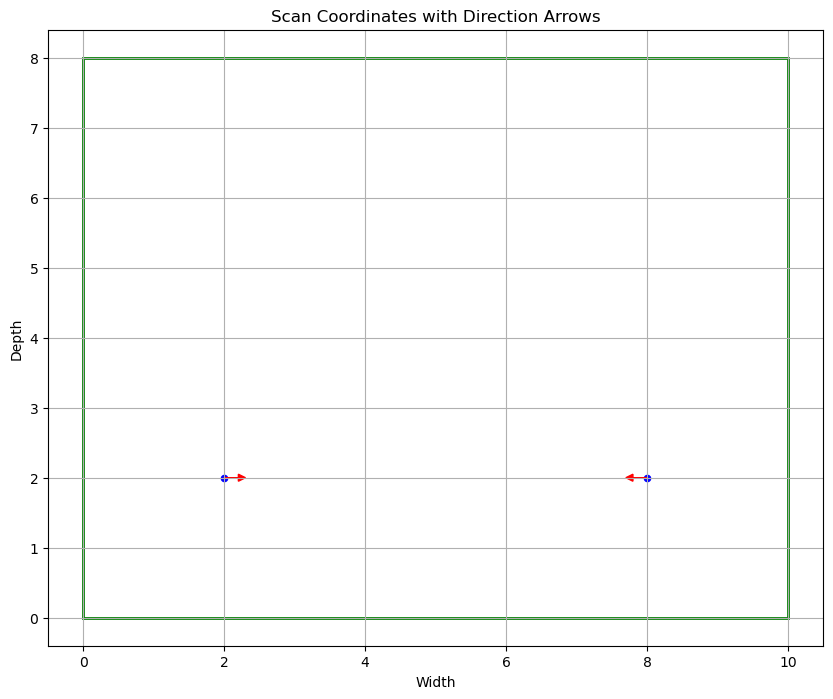

[(2.0, 2.0, 0), (8.0, 2.0, 3.141592653589793)]


In [25]:
from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.pyplot as plt

def generate_scan_coordinates(x_lim, y_lim, scan_radius):
    # Calculate number of vertical scan lines
    num_scan_lines = int(np.ceil((x_lim - (2 * scan_radius)) / (2 * scan_radius)))
    scan_lines = np.linspace(scan_radius, x_lim - scan_radius, num_scan_lines)
    scan_lines = [v for v in scan_lines]

    # Calculate vertical stop points
    num_scan_points = int(np.ceil((y_lim - (2 * scan_radius)) / (2 * scan_radius)))
    scan_points = np.linspace(scan_radius, y_lim - scan_radius, num_scan_points)

    # Define scan directions
    UP, DOWN = 1, -1
    current_direction = UP

    coordinates = []
    for scan_line in scan_lines:
        angle = 0 if current_direction == UP else np.pi
        for scan_point in scan_points:
            coordinates.append((scan_line, scan_point, angle))
        
        # Reverse direction and scan points for the next line
        current_direction *= -1
        scan_points = scan_points[::-1]

    return coordinates



def plot_scan_coordinates(coordinates, width, depth):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Extract x, y, and th from coordinates
    x, y, th = zip(*coordinates)
    
    # Plot points
    ax.scatter(x, y, c='blue', s=20)
    
    # Plot arrows
    for xi, yi, thi in coordinates:
        dx = 0.2 * np.cos(thi)
        dy = 0.2 * np.sin(thi)
        ax.arrow(xi, yi, dx, dy, head_width=0.1, head_length=0.1, fc='red', ec='red')
    
    # Set plot limits and labels
    # ax.set_xlim(0, x_lim)
    # ax.set_ylim(0, y_lim)
    ax.set_xlabel('Width')
    ax.set_ylabel('Depth')
    ax.set_title('Scan Coordinates with Direction Arrows')
    rect = Rectangle((0, 0), width, depth, fill=False, edgecolor='green', linewidth=2)
    ax.add_patch(rect)
    # Add grid
    ax.grid(True)
    
    plt.show()
    
# Example usage:
width = 10
depth = 8
max_scan_distance = 2
coords = generate_scan_coordinates(width, depth, max_scan_distance)
plot_scan_coordinates(coords, width, depth)

print(coords)